## 构建 Bernoulli Distribution 的 Multi-armed Bandit

In [1]:
import numpy as np
import matplotlib.pyplot as plt

定义 Multi-armed Bandit

In [2]:
class BernoulliBandit:
    def __init__(self, K):
        self.probs = np.random.rand(K)
        self.best_idx = np.argmax(self.probs)
        self.best_prob = self.probs[self.best_idx]
        self.K = K
    
    def step(self, k:int):
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0


In [3]:
# np.random.seed(1)

bernoulli_10_bandit = BernoulliBandit(10)
print("The distribution of bernoulli_10_bandit: ",bernoulli_10_bandit.probs)

print("The best arm index: ",bernoulli_10_bandit.best_idx)
print("The best arm probability: ",bernoulli_10_bandit.best_prob)

print("The probability of arm 3: ",bernoulli_10_bandit.probs[3])
x = bernoulli_10_bandit.step(3)
print("The result of arm 3: ",x)

The distribution of bernoulli_10_bandit:  [5.26760295e-01 1.49823697e-01 8.95418196e-01 7.76648408e-01
 5.74802623e-01 7.04504750e-01 4.46459435e-04 5.32196831e-02
 8.14549611e-01 4.34420136e-01]
The best arm index:  2
The best arm probability:  0.8954181957649379
The probability of arm 3:  0.7766484082375673
The result of arm 3:  1


定义一个 Solver 类来解决 Bandit 问题

In [4]:
class Solver:
    def __init__(self, bandit:BernoulliBandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)
        self.regret = 0
        self.actions = []   # 每一步的动作
        self.regrets = []   # 每一步的累积懊悔
    
    def update_regret(self, k):
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        raise NotImplementedError
    
    def run(self, num_steps):
        for _ in range(num_steps):
            k = self.run_one_step()
            self.actions.append(k)
            self.counts[k] += 1
            self.update_regret(k)
            


$\epsilon$-Greedy Policy 实现

In [5]:
class EpsilonGreedy(Solver):
    def __init__(self, bandit: BernoulliBandit, epsilon=0.01, init_prob=1.0):
        super().__init__(bandit)
        self.epsilon = epsilon
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.rand() < self.epsilon:
            k = int(np.random.randint(0, self.bandit.K))
        else:
            k = int(np.argmax(self.estimates))
        
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k



接下来画一个图来展示 Regret 变化过程

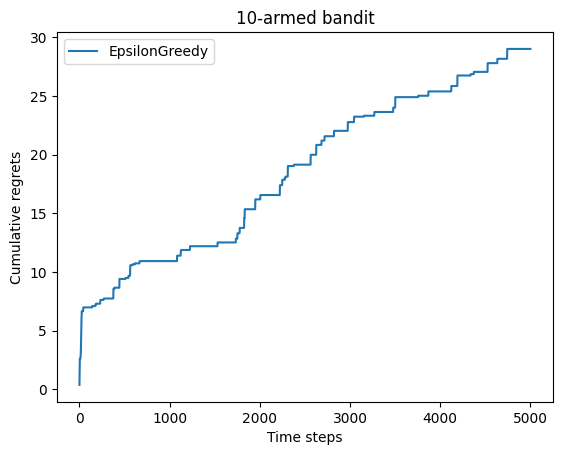

In [7]:
def plot_results(solvers: list[Solver], solver_names):
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label = solver_names[idx])

    plt.xlabel("Time steps")
    plt.ylabel("Cumulative regrets")
    plt.title("%d-armed bandit" % solvers[0].bandit.K)
    plt.legend()
    plt.show()

np.random.seed(None)
epsilon_greedy_solver = EpsilonGreedy(bernoulli_10_bandit)
epsilon_greedy_solver.run(5000)

plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])


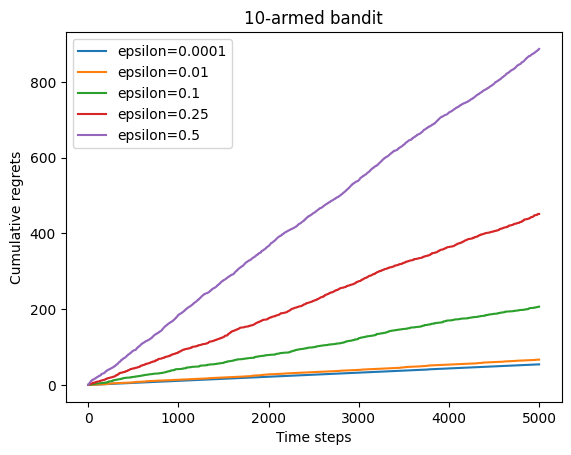

In [17]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bernoulli_10_bandit, epsilon=e) for e in epsilons
]

epsilon_greedy_solver_names = ["epsilon={}".format(e) for e in epsilons]

for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list, epsilon_greedy_solver_names)



可以看出不论设计 $\epsilon$ 为多少，cululative regrets 都是线性增长的。
接下来我们尝试采用让 $\epsilon$ 递减的方法，看看是否可以得到一个次线性的结果

In [8]:
class DecayingEpsilonGreedy(Solver):
    def __init__(self, bandit, init_prob = 1.0):
        super().__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.rand() < 1 / self.total_count:
            k = int(np.random.randint(0, self.bandit.K))
        else:
            k = int(np.argmax(self.estimates))
        
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

epsilon值衰减的贪婪算法的累积懊悔为： 10.757887402084211


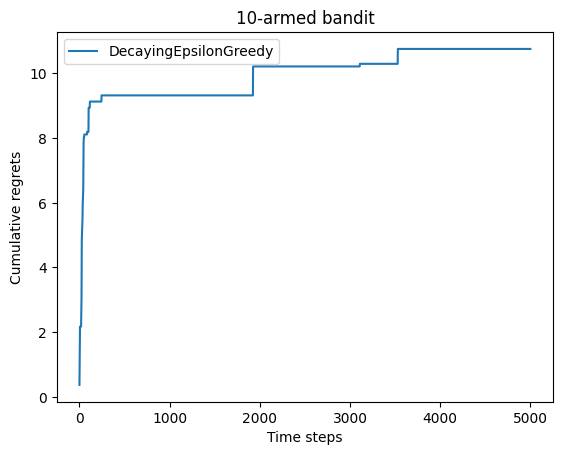

In [9]:
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bernoulli_10_bandit)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

Upper Confidence Boundary Algorithm 的原理

这个算法基于 **霍夫丁不等式（Hoeffding's inequality）**
根据这个不等式，我们可以得到：
$$
\mathbb{P}\{\mathbb{E}[x] \ge \bar{x}_n + u \} \le e^{-2nu^2}
$$
带入 $\hat{Q_t}(a) = \bar{x}$ 我们可以得到 $Q_t(a) < \hat{Q_t}(a) + \hat{U_t}(a) $ 以 $1-p$ 概率实现，所以当 $p$ 很小时，我们有很大概率得到上界

我们 define
$$
p = e^{-2N_t(a)U_t(a)^2}, \quad U_t(a) \text{ is an uncertainty measure of action a}
$$
这样可以反解得到
$$
U_t(a) = \sqrt{\frac{-log p}{2N_t(a)}}
$$
所以只需要根据需求定义一个很小的 $p$，我们就可以得到这个 arm 的置信上界


Upper Confidence Boundary Algorithm 的实现

这里我们设置 $p = \frac{1}{t}$，为了防止分母为零，为每个拉杆次数加一，
i.e.，
$$
U_t(a) = \sqrt{\frac{-log p}{2(N_t(a)+1)}}
$$
同时用一个参数 $c$ 来控制比重
$$
a = \argmax_{a \in A} \hat{Q}(a) + c \cdot \hat{U} (a)
$$

In [17]:
class UCB(Solver):
    def __init__(self, bandit: BernoulliBandit, coef, init_prob = 1.0):
        super().__init__(bandit)
        self.total_count = 0
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef

    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + \
            self.coef * np.sqrt(\
                -np.log10(1 / self.total_count)/(2*(self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k
        

上置信界算法的累积懊悔为： 78.27324373971993


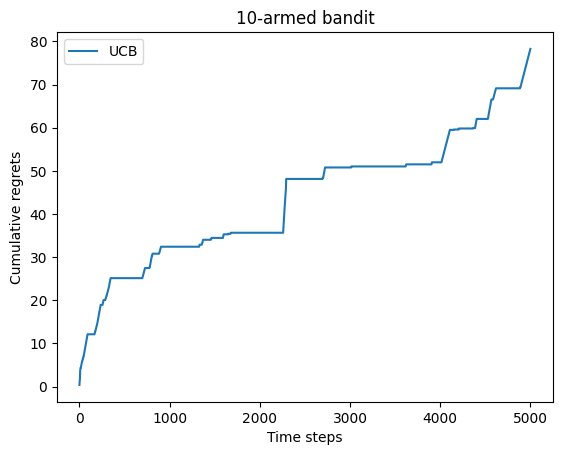

In [19]:
coef = 1  # 控制不确定性比重的系数
UCB_solver = UCB(bernoulli_10_bandit, coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：', UCB_solver.regret)
plot_results([UCB_solver], ["UCB"])

# Thompson sampling 算法原理

### 贝叶斯派的思想：

我们 **不** 把参数 $\theta$ 看作一个固定值，而是看作一个**我们不确定的随机变量**。

### Main Idea

这个算法的基础是需要有一个针对 output 的模型假设，写出他的似然函数估计，设出他的参数 $\theta$

然后我们需要维护一个关于他参数的共轭分布

根据不断输入的信息更新后验分布，我们可以得到有更多后验信息的共轭分布，这里的似然函数永远不变，通过 **对不同 Arm 的共轭分布进行取样**，再带回 **模型期望** 进行计算，选择 **最大期望（预期收益）** 作为下一步的目标

> **共轭分布：**
当你选择的先验分布 (Prior) 和似然函数 (Likelihood) 组合后，计算出的后验分布 (Posterior) 与先验分布属于同一种类型的概率分布。在这种情况下，这个先验分布被称为似然函数的**共轭先验 (Conjugate Prior)**。
这基于 $P(\theta | \text{Data}) = \frac{P(\text{Data} | \theta) \times P(\theta)}{P(\text{Data})}$  这个后验分布的获取过程。这里的 $P(Data)$ 作为一个参数，并不影响 $f(\theta)$ ，或者说  $p(\theta | Data) \propto p(Data | \theta) \times p(\theta)$ 而我们的目标就是让这个后验尽可能简单，最好的方法就是维持 $P(\theta)$ 的格式一致性
>

In [22]:
class ThompsonSampling(Solver):
    def __init__(self, bandit: BernoulliBandit, init_prob = 1.0):
        super().__init__(bandit)
        self._a = np.ones(self.bandit.K)
        self._b = np.ones(self.bandit.K)

    def run_one_step(self):
        samples = np.random.beta(self._a,self._b)
        k = np.argmax(samples)
        r = self.bandit.step(k)
        self._a[k] += r
        self._b[k] += (1 - r) 
        return k


汤普森采样算法的累积懊悔为： 32.96100450095438


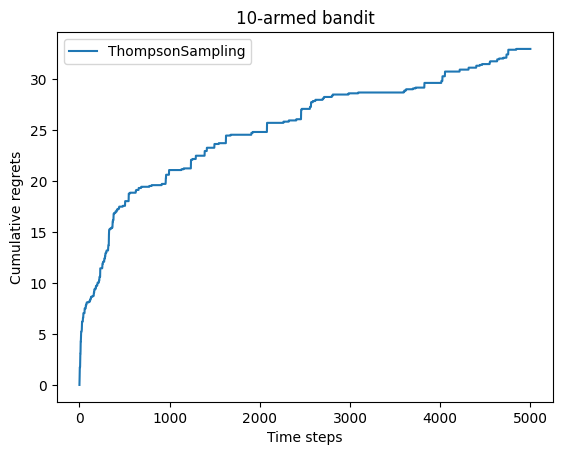

In [26]:
thompson_sampling_solver = ThompsonSampling(bernoulli_10_bandit)
thompson_sampling_solver.run(5000)
print('汤普森采样算法的累积懊悔为：', thompson_sampling_solver.regret)
plot_results([thompson_sampling_solver], ["ThompsonSampling"])

通过实验我们可以得到以下结论：$\epsilon$-Greedy 算法的累积懊悔是随时间线性增长的，而另外 3 种算法（ $\epsilon$-Decaying Greedy算法、UCB 算法、Thompson Sampling算法）的累积懊悔都是随时间次线性增长的（具体为对数形式增长）。